<a href="https://colab.research.google.com/github/xfwangxf/cis700-homework-1/blob/main/my_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text adventure game

This Python notebook builds a simple text advenutre game inspired by the [Adventuron Classroom](https://adventuron.io/classroom/) design by Chris Ainsley of Adventuron Software Limited.

The main components are:
1. __The parser__, which interprets the player's commands.
2. __The game__, which represents the world (a collection of __locations__ and __items__), and describes what the player sees.
3. __The data__, which you input to create your own unique game.

## The Game Class
The game keeps track of the state of the world, and describes what the player sees as they move through different locations.

In [ ]:
from collections import defaultdict

In [ ]:
class Game:
  """The Game class represents the world.  Internally, we use a 
     graph of Location objects and Item objects, which can be at a 
     Location or in the player's inventory.  Each locations has a set of
     exits which are the directions that a player can move to get to an
     adjacent location. The player can move from one location to another
     location by typing a command like "Go North".
  """

  def __init__(self, start_at):
    # start_at is the location in the game where the player starts
    self.curr_location = start_at
    self.curr_location.has_been_visited = True
    # inventory is the set of objects that the player has collected
    self.inventory = {}
    # Print the special commands associated with items in the game (helpful 
    # for debugging and for novice players).
    self.print_commands = True

  def describe(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    self.describe_current_location()
    self.describe_exits()
    self.describe_items()

  def describe_current_location(self):
    """Describe the current location by printing its description field."""
    print(self.curr_location.description)

  def describe_exits(self):
    """List the directions that the player can take to exit from the current
       location."""
    exits = []
    for exit in self.curr_location.connections.keys():
      if exit == "back" or exit == "hidden_enter":
        continue
      exits.append(exit.capitalize())
    if len(exits) > 0:
      print("Exits: ", end = '')
      print(*exits, sep = ", ",)
  
  def describe_items(self):
    """Describe what objects are in the current location."""
    if len(self.curr_location.items) > 0:
      print("You see: ")
      for item_name in self.curr_location.items:
        item = self.curr_location.items[item_name]
        print(item.description)
        if self.print_commands:
          special_commands = item.get_commands()
          for cmd in special_commands:
            print('\t', cmd)

  def add_to_inventory(self, item):
    """Add an item to the player's inventory."""
    self.inventory[item.name] = item
  
  def is_in_inventory(self,item):
    return item.name in self.inventory

  def get_items_in_scope(self):
    """Returns a list of items in the current location and in the inventory"""
    items_in_scope = []
    for item_name in self.curr_location.items:
      items_in_scope.append(self.curr_location.items[item_name])
    for item_name in self.inventory:
      items_in_scope.append(self.inventory[item_name])
    return items_in_scope

## Locations

Locations Locations are the places in the game that a player can visit.  They contain connects to other locations and items that the player can interact with.

In [ ]:
class Location:
  """Locations are the places in the game that a player can visit.
     Internally they are represented nodes in a graph.  Each location stores
     a description of the location, any items in the location, its connections
     to adjacent locations, and any blocks that prevent movement to an adjacent
     location.  The connections is a dictionary whose keys are directions and
     whose values are the location that is the result of traveling in that 
     direction.  The travel_descriptions also has directions as keys, and its 
     values are an optional short desciption of traveling to that location.
  """
  def __init__(self, name, description):
    # A short name for the location
    self.name = name
    # A description of the location
    self.description = description
    # The properties should contain a key "end_game" with value True
    # if entering this location should end the game
    self.properties = defaultdict(bool)
    # Dictionary mapping from directions to other Location objects
    self.connections = {}
    # Dictionary mapping from directions to text description of the path there
    self.travel_descriptions = {}
    # Dictionary mapping from item name to Item objects present in this location
    self.items = {}
    # Dictionary mapping from direction to Block object in that direction
    self.blocks = {}
    # Flag that gets set to True once this location has been visited by player
    self.has_been_visited = False

  def set_property(self, property_name, property_bool=True):
    """Sets the property of this item"""
    self.properties[property_name] = property_bool
  
  def get_property(self, property_name):
    """Gets the boolean value of this property for this item (defaults to False)"""
    return self.properties[property_name]

  def add_connection(self, direction, connected_location, travel_description=""):
    """Add a connection from the current location to a connected location.
       Direction is a string that the player can use to get to the connected
       location.  If the direction is a cardinal direction, then we also 
       automatically make a connection in the reverse direction."""
    direction = direction.lower()
    self.connections[direction] = connected_location
    self.travel_descriptions[direction] = travel_description
    if direction == 'north':
      connected_location.connections["south"] = self
      connected_location.travel_descriptions["south"] = ""
    if direction == 'south':
      connected_location.connections["north"] = self
      connected_location.travel_descriptions["north"] = ""
    if direction == 'east':
      connected_location.connections["west"] = self
      connected_location.travel_descriptions["west"] = ""
    if direction == 'west':
      connected_location.connections["east"] = self
      connected_location.travel_descriptions["east"] = ""
    if direction == 'up':
      connected_location.connections["down"] = self
      connected_location.travel_descriptions["down"] = ""
    if direction == 'down':
      connected_location.connections["up"] = self
      connected_location.travel_descriptions["up"] = ""
    if direction == 'in':
      connected_location.connections["out"] = self
      connected_location.travel_descriptions["out"] = ""
    if direction == 'out':
      connected_location.connections["in"] = self
      connected_location.travel_descriptions["in"] = ""
    if direction == 'inside':
      connected_location.connections["outside"] = self
      connected_location.travel_descriptions["outside"] = ""
    if direction == 'outside':
      connected_location.connections["inside"] = self
      connected_location.travel_descriptions["inside"] = ""


  def add_item(self, name, item):
    """Put an item in this location."""
    self.items[name] = item

  def remove_item(self, item):
    """Remove an item from this location (for instance, if the player picks it
       up and puts it in their inventory)."""
    self.items.pop(item.name)


  def is_blocked(self, direction, game):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
        return False
    (block_description, preconditions) = self.blocks[direction]
    if check_preconditions(preconditions, game):
      # All the preconditions have been met.  You may pass.
      return False
    else: 
      # There are still obstalces to overcome or puzzles to solve.
      return True

  def get_block_description(self, direction):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
      return ""
    else:
      (block_description, preconditions) = self.blocks[direction]
      return block_description

  def add_block(self, blocked_direction, block_description, preconditions):
    """Create an obstacle that prevents a player from moving in the blocked 
       location until the preconditions are all met."""
    self.blocks[blocked_direction] = (block_description, preconditions)

## Checking Preconditions 
In text adventure games it's common to block a player's progress by creating blocks that prevent them from moving to a location.  For instance, a drawbridge might have a troll that you need to get rig of before you can cross into the castle, or a locked door might prevent you from entering a building until you have a key.  

This is a function that you can modify to include other preconditions.

In [ ]:
def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      item = preconditions[check]
      if not game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print("You don't have the %s" % item.name)
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print("You aren't in the correct location")
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s isn't in this location" % item.name)
    # todo - add other types of preconditions
  return all_conditions_met

## Items
Items are objects that a player can get, or scenery that a player can examine. We could also implement people as items.  

In [ ]:
class Item:
  """Items are objects that a player can get, or scenery that a player can
     examine."""
  def __init__(self,
               name,
               description,
               examine_text="",
               take_text="",
               start_at=None):
    # The name of the object
    self.name = name
    # The default description of the object.
    self.description = description
    # The detailed description of the player examines the object.
    self.examine_text = examine_text
    # Text that displays when player takes an object.
    self.take_text = take_text if take_text else ("You take the %s." % self.name)
    self.properties = defaultdict(bool)
    self.properties["gettable"] = True
    # The location in the Game where the object starts.
    if start_at:
      start_at.add_item(name, self)
    self.commands = {}


  def get_commands(self):
    """Returns a list of special commands associated with this object"""
    return self.commands.keys()

  def set_property(self, property_name, property_bool=True):
    """Sets the property of this item"""
    self.properties[property_name] = property_bool
  
  def get_property(self, property_name):
    """Gets the boolean value of this property for this item (defaults to False)"""
    return self.properties[property_name]

  def add_action(self, command_text, function, arguments, preconditions={}):
    """Add a special action associated with this item"""
    self.commands[command_text] = (function, arguments, preconditions)

  def do_action(self, command_text, game):
    """Perform a special action associated with this item"""
    end_game = False  # Switches to True if this action ends the game.
    if command_text in self.commands:
      function, arguments, preconditions = self.commands[command_text]
      if check_preconditions(preconditions, game):
        end_game = function(game, arguments)
    else:
      print("Cannot perform the action %s" % command_text)
    return end_game

## The Parser
The parser is the module that handles the natural language understanding in the game.  The players enter commands in text, and the parser interprets them and performs the actions that the player intends.  This is the module with the most potential for improvement using modern natural language processing.  The implementation that I have given below only uses simple keyword matching.

In [ ]:
class Parser:
  """The Parser is the class that handles the player's input.  The player 
     writes commands, and the parser performs natural language understanding
     in order to interpret what the player intended, and how that intent
     is reflected in the simulated world. 
  """
  def __init__(self, game):
    # A list of all of the commands that the player has issued.
    self.command_history = []
    # A pointer to the game.
    self.game = game

  def get_player_intent(self,command):
    command = command.lower()
    if "," in command:
      # Let the player type in a comma separted sequence of commands
      return "sequence"
    elif self.get_direction(command):
      # Check for the direction intent
      return "direction"
    elif command.lower() == "look" or command.lower() == "l":
      # when the user issues a "look" command, re-describe what they see
      return "redescribe"
    elif "examine " in command or command.lower().startswith("x "):
      return "examine"
    elif  "take " in command or "get " in command:
      return "take"
    elif "drop " in command:
      return "drop"
    elif "inventory" in command or command.lower() == "i":
      return "inventory"
    elif "try" in command:
      return "solve"
    else: 
      for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return "special"

  def parse_command(self, command):
    # add this command to the history
    self.command_history.append(command)

    # By default, none of the intents end the game. The following are ways this
    # flag can be changed to True.
    # * Going to a certain place.
    # * Entering a certain special command
    # * Picking up a certain object.
    end_game = False

    # Intents are functions that can be executed
    intent = self.get_player_intent(command)
    if intent == "direction":
      end_game = self.go_in_direction(command)
    elif intent == "redescribe":
      self.game.describe()
    elif intent == "examine":
      self.examine(command)
    elif intent == "take":
      end_game = self.take(command)
    elif intent == "drop":
      self.drop(command)
    elif intent == "inventory":
      self.check_inventory(command)
    elif intent == "special":
      end_game = self.run_special_command(command)
    elif intent == "sequence":
      end_game = self.execute_sequence(command)
    elif intent == "solve":
      end_game = self.solve(command)
    else:
      print("I'm not sure what you want to do.")
    return end_game

  ### Intent Functions ###

  def go_in_direction(self, command):
    """ The user wants to in some direction """
    direction = self.get_direction(command)
    print("*", direction)

    if direction:
      if direction in self.game.curr_location.connections:
        if self.game.curr_location.is_blocked(direction, self.game):
          # check to see whether that direction is blocked.
          print(self.game.curr_location.get_block_description(direction))
        else:
          # if it's not blocked, then move there 
          self.game.curr_location = self.game.curr_location.connections[direction]

          # If moving to this location ends the game, only describe the location
          # and not the available items or actions.
          if self.game.curr_location.get_property('end_game'):
            self.game.describe_current_location()
          else:
            self.game.describe()
      else:
        print("You can't go %s from here." % direction.capitalize())
    return self.game.curr_location.get_property('end_game')

  def check_inventory(self,command):
    """ The player wants to check their inventory"""
    if len(self.game.inventory) == 0:
      print("You don't have anything.")
    else:
      descriptions = []
      for item_name in self.game.inventory:
        item = self.game.inventory[item_name]
        descriptions.append(item.description)
      print("You have: " + ", ".join(descriptions))
  

  def examine(self, command):
    """ The player wants to examine something """
    command = command.lower()
    matched_item = False
    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
        break
    # check whether any of the items in the inventory match the command
    for item_name in self.game.inventory:
      if item_name in command:
        item = self.game.inventory[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
    # fail
    if not matched_item:
      print("You don't see anything special.")


  def take(self, command):
    """ The player wants to put something in their inventory """
    command = command.lower()
    matched_item = False

    # This gets set to True if posession of this object ends the game.
    end_game = False

    # This gets set to True if posession of this object sends you back to NPC.
    back = False

    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.get_property('gettable'):
          self.game.add_to_inventory(item)
          self.game.curr_location.remove_item(item)
          print(item.take_text)
          end_game = item.get_property('end_game')
          back = item.get_property('back')
        else:
          print("You cannot take the %s." % item_name)
        matched_item = True
        break
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          print("You already have the %s." % item_name)
          matched_item = True
    # fail
    if not matched_item:
      print("You can't find it.")

    if back:
      self.game.curr_location = self.game.curr_location.connections["back"]
      print(self.game.describe())

    return end_game

  def drop(self, command):
    """ The player wants to remove something from their inventory """
    command = command.lower()
    matched_item = False
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          matched_item = True
          item = self.game.inventory[item_name]
          self.game.curr_location.add_item(item_name, item)
          self.game.inventory.pop(item_name)
          print("You drop the %s." % item_name)
          break
    # fail
    if not matched_item:
      print("You don't have that.")


  def run_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return item.do_action(special_command, self.game)

  def execute_sequence(self, command):
    for cmd in command.split(","):
      cmd = cmd.strip()
      self.parse_command(cmd)

  def get_direction(self, command):
    command = command.lower()
    if command == "n" or "north" in command:
      return "north" 
    if command == "s" or "south" in command:
      return "south"
    if command == "e" or "east" in command: 
      return "east"
    if command == "w" or "west" in command:
      return "west"
    if command == "up":
      return "up"
    if command == "down":
      return "down"
    if command.startswith("go out"):
      return "out"
    if command.startswith("go in"):
      return "in"
    if command == "enter":
      return "enter"
    if command == "walk through":
      return "walk through"
    for exit in self.game.curr_location.connections.keys():
      if command == exit.lower() or command == "go " + exit.lower():
        return exit
    return None
  
  def solve(self, command):
    command = command.lower()
     # This gets set to True if posession of this object ends the game.
    end_game = False

    # This gets set to True if posession of this object sends you back to NPC.
    back = False

    destroy_item(self.game, (self.game.inventory["a bag of air"], "", ""))

    if "roses are red" in command:
      end_game = True
      print('Congratulations! You passed this game!')

    else:
      back = True
      print("Wrong answer. You need to start over again.")

    if back:
      self.game.curr_location = self.game.curr_location.connections["back"]
      print(self.game.describe())

    return end_game


## Special functions
Many times we want to add special behavior to items in the game.  For instance, we might want to be able to _pick a rose_ from a _rosebush_, or the _eat_ a _fish_.  In this implementation we do this in a pretty generic way by allowing the game developer to call ```Item.add_action(cmd,function,argment,preconditions)``` where ```function``` is any Python function. Some example of functions are defined below.

These functions should return True if the game is ended by the action, False otherwise.

In [ ]:
def add_item_to_inventory(game, *args):
  """ Add a newly created Item and add it to your inventory."""
  (item, action_description, already_done_description) = args[0]
  if(not game.is_in_inventory(item)):
    print(action_description)
    game.add_to_inventory(item)
  else:
    print(already_done_description)
  return False

def describe_something(game, *args):
  """Describe some aspect of the Item"""
  (description) = args[0]
  print(description)
  return False

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description,already_done_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print(action_description)
  else:
    print(already_done_description)
  return False

def end_game(game, *args):
  """Ends the game."""
  end_message = args[0]
  print(end_message)
  return True

def back_to_NPC(game, *args):
  (description) = args[0]
  print(description)
  game.curr_location = game.curr_location.connections["back"]
  print(game.describe())
  return False

def perform_multiple_actions(game, *args):
  """Perform a sequence of actions"""
  """sample args here: 
      ([(destroy_item, (branch,"You swing your branch against the guard. It shatters to pieces.","You already tried that.")),
      (destroy_item, (guard,"The guard slumps over, unconscious.",""))]
  """
  for actions in args[0]:
    function, params = actions
    function(game, params)
  return False
  
def create_item(game, *args):
  (item, action_description) = args[0]
  if item.name not in game.curr_location.items:
    game.curr_location.add_item(item.name, item)
    print(action_description)
  return False

def talk_to_NPC(game, *args):
  (description) = args[0]
  print(description)
  game.curr_location = game.curr_location.connections["hidden_enter"]
  print(game.describe())
  return False



## Game Data

Here's where you can define the locations and items in your game.  To get you started, I defined a super-simple fishing game, which contains the first 3 locations of __Action Castle__ by Jared A. Sorensen, which is part of the awesome book [Parsley](http://www.memento-mori.com/parsely-products/parsely-pdf).  

You can play through the whole game with the following commands:
1. take pole
2. go out
3. south 
4. catch fish with pole
5. eat fish

In [ ]:
def build_game():
  # Locations
  
  # Intro

  Your_room = Location("Your room", "It‘s another sleepless night and you’re sitting in front of your computer dozing off while trying to finish your CIS-700 assignment. Suddenly your computer starts flashing and there are green characters falling down. You looked confused. While checking the calendar, a loud *Beep* sound and a giant blue portal came out from nowhere is sitting at the center of room. ")
  The_Space_Betweens = Location("The Space Betweens","You came to a white room with one wall filled with screens.")
  #The_Sapce_Betweens_Return = Location("The Space Betweens","You are back to the Space Between.")
  the_afterlife = Location("The Afterlife", "Your data seems to be destoried and your will be traped here forever. GAME OVER.")
  the_afterlife.set_property('end_game', True)
  Portal_1 = Location("A Blue Portal","It appears to be a long light tunnel.") 

  #World 1
  cottage = Location("Cottage", "You are standing in a small cottage. This cottage looks suspiciously similar to the Action Castle game you were working on before came here.")
  garden_path = Location("Garden Path", "You are standing on a lush garden path. There are two cottages around you and the one you came from is at North.")
  cottage_east = Location("East Cottage", "You are standing in a small cottage. There is a green portal in it.")
  cottage_west = Location("West Cottage", "You are standing in a small cottage.")
  fishing_pond = Location("Fishing Pond", "You are at the edge of a small fishing pond.")
  Portal_2 = Location("A Green Portal","a long light tunnel again")

  
  #World 2
  wagon = Location("Wagon", "You are sitting on the wagon")
  castle = Location("Castle","You are entering a castle, see a sentry tower at the north coner")
  sentry_tower = Location("Sentry Tower","You see an orange portal and a dragon")
  Portal_3 = Location("An Orange Portal","a long light tunnel again")
  dragon_body = Location("A dead dragon body ","You come close to the dead body of the dragon and see a light bulb")

  #World 3
  space_ship = Location("A Space ship","there is no oxygen")
  arsenal = Location("Arsenal","advence weapons laying around")
  secret_chamber = Location("A secret chamber","you have only one time to try")

  # Connections-Intro
  Your_room.add_connection("enter",The_Space_Betweens)
  The_Space_Betweens.add_connection("hidden_enter",Portal_1)
  Portal_1.add_connection("walk through", cottage)

  # Connections-World 1
  cottage.add_connection("out", garden_path)
  cottage.add_connection("back", The_Space_Betweens)
  
  garden_path.add_connection("east", cottage_east)
  garden_path.add_connection("west", cottage_west)
  garden_path.add_connection("south", fishing_pond)
  cottage_east.add_connection("enter",Portal_2)

  # Connections-World 2
  Portal_2.add_connection("walk through",wagon)
  wagon.add_connection("out",castle)
  castle.add_connection("north",sentry_tower)
  sentry_tower.add_connection("enter",Portal_3) 

  # Connections-World 3
  Portal_3.add_connection("Decide not to go", The_Space_Betweens)
  space_ship.add_connection("Room 1",secret_chamber)
  space_ship.add_connection("Room 2",arsenal)
  secret_chamber.add_connection("back", The_Space_Betweens)
  arsenal.add_connection("back", The_Space_Betweens)

  # condition needed
  sentry_tower.add_connection("down",dragon_body)
  sentry_tower.add_connection("back", The_Space_Betweens)
  Portal_3.add_connection("walk through",space_ship)
 

  # Items that you can pick up
  fishing_pole = Item("pole", "a fishing pole", "A SIMPLE FISHING POLE.", start_at=cottage)
  potion = Item("potion", "a poisonous potion", "IT'S BRIGHT GREEN AND STEAMING.", start_at=cottage, take_text='As you near the potion, the fumes cause you to faint. You will be sent back.')
  potion.set_property('back', True)
  sword = Item("sword","a shinny sword", examine_text="A light sword", start_at=cottage_west)
  plastic_bag = Item("plastic bag","an empty plastic bag",examine_text="sea project",start_at=None)
  wisdom_of_dragon = Item("wisdom of dragon","wisdom of dragon",examine_text="Remember: roses are red, violets are blue, unexpected indent on line 22.",start_at=dragon_body)
  energy_sword = Item("energy sword","a very powerful sword","Hummmm…whirrrr…tchowwwwww! YOU CAN FELL THE LIGHT ENERGY",start_at=arsenal)

  # Sceneary (not things that you can pick up)
  a_man = Item("man","a man sitting in front of the screens",examine_text="When you tried to talk to him, he seems very surprised by your appearance and yelled at you  'This is the Space Between , no one is allowed to be here, go back to your world!'",start_at=The_Space_Betweens)
  a_man.set_property("gettable", False)
  pond = Item("pond", "a small fishing pond", "THERE ARE FISH IN THE POND.", start_at=fishing_pond)
  pond.set_property("gettable", False)
  chicken = Item("chicken","a peaceful chicken just hanging around","seems a good idea just leave the chicken alone",start_at=garden_path)
  chicken.set_property("gettable", False)
  a_medieval_man = Item("a medieval man","a medeival sitting on the same wagon as you are",start_at=wagon)
  a_medieval_man.set_property("gettable", False)
  dragon = Item("a dragon","A mighty dragon",examine_text="you might be able to kill it",start_at=sentry_tower)
  dragon.set_property("gettable", False)
  screen = Item('screen', 'There is a riddle on the screen', examine_text="Tell me the poem you learnt from the dragon, starting with 'TRY'", start_at=secret_chamber)
  screen.set_property("gettable", False)
  
  # item to be created
  bagged_air = Item("a bag of air","an bag of air that might help you survive somewhere",examine_text="you can look through the bag",start_at=None)
  dead_dragon = Item("dead_dragon", "you have killed the dragon with advanced alian technology", "A light ball appeared.", start_at=dragon_body)
 
  # Add blocks
  sentry_tower.add_block("down", "There's a dragon blocking your way", preconditions = {"location_has_item": dead_dragon})
  Portal_3.add_block("walk through", "The place you are heading to has no oxygen", preconditions = {"inventory_contains":bagged_air})
 
  #drawbridge.add_block("east", "The troll blocks your way.", preconditions = {"location_has_item_h": fish})
  #courtyard.add_block("east", "The guard refuses to let you pass.", preconditions = {"location_has_item_h":unconscious_guard})
  #tower_stairs.add_block("up", "The door is locked.", preconditions = {"location_has_item_h":unlocked_door})
  #dungeon_stairs.add_block("down", "It's too dark to see.", preconditions = {"inventory_contains_h":lighted_lamp})

  # Add special functions to your items
  a_man.add_action("talk to npc", talk_to_NPC, ('This is the Space Between , no one is allowed to be here, go back to your world! Otherwise, I will send you to an unknown world in a few second.'))
  pond.add_action("catch fish",  describe_something, ("You reach into the pond and try to catch a fish with your hands, but they are too fast."))
  pond.add_action("catch fish with pole",  add_item_to_inventory, (plastic_bag, "You dip your hook into the pond and catch a plastic bag.","You weren't able to catch another fish."), preconditions={"inventory_contains":fishing_pole})
  a_medieval_man.add_action("talk to him",describe_something, ('Hi! You are awake.') )
  
  plastic_bag.add_action("bag some air", perform_multiple_actions, ([(add_item_to_inventory, (bagged_air, "You bagged some air", "")), (destroy_item, (plastic_bag, "", ""))]), preconditions={"inventory_contains":plastic_bag})
  dragon.add_action("attack the dragon with energy sword", perform_multiple_actions, 
      ([
      (destroy_item, (dragon,"You have successfully killed the dragon and a barbecue smell is emitted from the body where the energy sword has been slashed.","")),
      (create_item, (dead_dragon,"The dragon's body lies on the ground.")),
      ]), preconditions={"inventory_contains":energy_sword , "location_has_item": dragon})  
  dragon.add_action("attack without energy sword", back_to_NPC, ('You can not beat the dragon with your hands. You will be sent back to the space in betweens.'), preconditions={'location_has_item': dragon})
  energy_sword.add_action('pick the energy sword', perform_multiple_actions, ([(add_item_to_inventory, (energy_sword, "You got the energy sword", "")), (back_to_NPC, ('However, you are running out of oxygen. You will be sent back to the space in betweens.')), (destroy_item, (bagged_air, "", ""))]), preconditions={"inventory_contains":bagged_air})
  return Game(Your_room)


# Play the game
This small snippet of code is what you need to run the game.  Behold! The magestic prompt! 

In [ ]:
def game_loop():
  game = build_game()
  parser = Parser(game)
  game.describe()

  command = ""
  while not (command.lower() == "exit" or command.lower == "q"):
    command = input(">")
    end_game = parser.parse_command(command)
    if end_game:
      return

game_loop()
print('THE GAME HAS ENDED.')

It‘s another sleepless night and you’re sitting in front of your computer dozing off while trying to finish your CIS-700 assignment. Suddenly your computer starts flashing and there are green characters falling down. You looked confused. While checking the calendar, a loud *Beep* sound and a giant blue portal came out from nowhere is sitting at the center of room. 
Exits: Enter
>enter
* enter
You came to a white room with one wall filled with screens.
You see: 
a man sitting in front of the screens
	 talk to npc
>talk to npc
This is the Space Between , no one is allowed to be here, go back to your world! Otherwise, I will send you to an unknown world in a few second.
It appears to be a long light tunnel.
Exits: Walk through
None
>walk through
* walk through
You are standing in a small cottage. This cottage looks suspiciously similar to the Action Castle game you were working on before came here.
Exits: Out
You see: 
a fishing pole
a poisonous potion
>get pole
You take the pole.
>out
* 

# Visualize your game
The code below allows you to create a directed graph that shows the locations in your game and how they are connected.  You can also save a PDF of your graph to your Google Drive with the `save_to_drive` method.  The output file will be called `game-visualization.pdf`.

The dead_dragon isn't in this location
You don't have the a bag of air
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


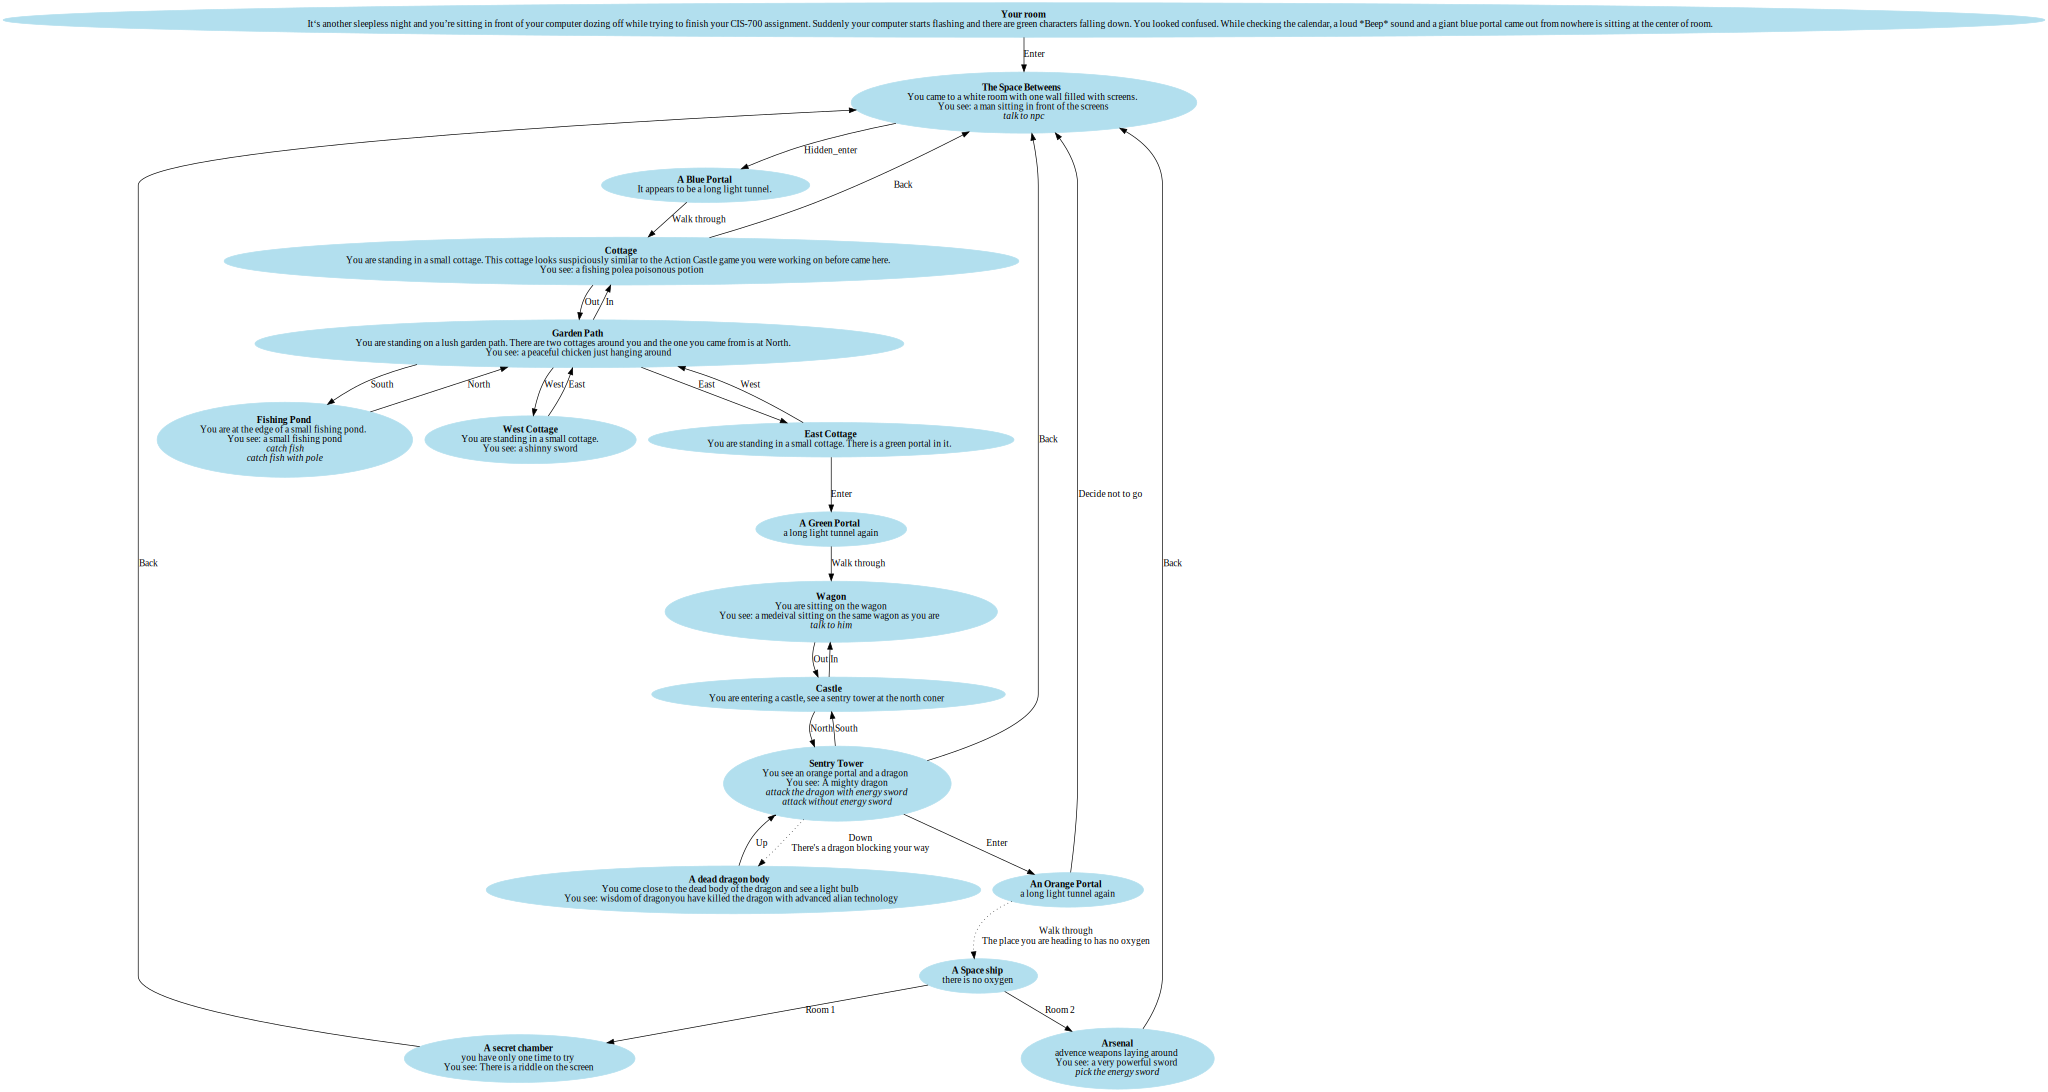

In [ ]:
#!pip install graphviz
from graphviz import Digraph
from IPython.display import Image
import queue

def DFS(game, graph):
  """Do a depth-first-search traversal of the locations in the game
     starting at the start location, and create a GraphViz graph 
     to vizualize the connections between the locations, and the items
     that are located at each location."""
  start_location = game.curr_location
  frontier = queue.Queue()
  frontier.put(start_location)
  visited = {}
  visited[start_location.name] = True

  while not frontier.empty():
    current_location = frontier.get()
    game.curr_location = current_location
    name = current_location.name
    description = current_location.description
    items = current_location.items
    items_html = describe_items(current_location)
    html = "<<b>%s</b><br />%s<br />%s>" % (name, description, items_html)
    # Create a new node in the graph for this location
    graph.node(name, label=html)  

    connections = current_location.connections
    for direction in connections.keys():
      next_location = connections[direction]
      if not current_location.is_blocked(direction, game):
        # Create an edge between the current location and its successor
        graph.edge(name, next_location.name, label=direction.capitalize())
      else:
        # Create a dotted edge for connected locations that are blocked
        block_description = "%s\n%s" % (direction.capitalize(), current_location.get_block_description(direction))
        graph.edge(name, next_location.name, label=block_description, style="dotted")
      if not next_location.name in visited:
        visited[next_location.name] = True
        frontier.put(next_location)

def describe_items(location, print_commands=True):
    """Describe what objects are in the current location."""
    items_html = ""
    if len(location.items.keys()) > 0:
      items_html = "You see: "
    for item_name in location.items:
      item = location.items[item_name]
      items_html += item.description
      if print_commands:
        special_commands = item.get_commands()
        for cmd in special_commands:
          items_html += "<br/><i>%s</i>" % cmd
    return items_html

def save_to_drive(graph):
  from google.colab import drive
  drive.mount('/content/drive/')
  graph.render('/content/drive/My Drive/game-visualization', view=True)  

graph = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})
game = build_game()
DFS(game, graph)
save_to_drive(graph)
graph
